**Автор: Анна Смелова**

## Решение домашнего задания к уроку 5 "Случайный лес"

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

### Задание 1
Используя файл Lesson_5_extended.ipynb (он в web5.zip в материалах):
#### Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [3]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=100, n_features=2, n_informative=2, 
                                                                 n_classes=4, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=9)

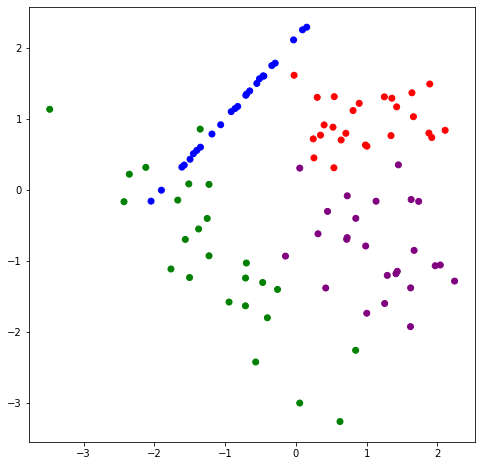

In [4]:
# визуализируем сгенерированные данные
colors = ListedColormap(['green', 'blue', 'purple', 'red'])
light_colors = ListedColormap(['lightgreen', 'lightblue', 'violet', 'lightcoral'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [5]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [7]:
# Класс дерева
class Tree:
    
    def __init__(self, max_tree_depth_stop=100, # максимальная глубина дерева
                 max_leaf_num_stop=100, # максимальное количество листьев
                 min_leaf_object_stop=1, # максимальное количество объектов в листе
                 single_class_stop=False): # остановка, если в узле объекты одного класса
        self.max_depth = max_tree_depth_stop
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_num_stop
        self.min_objects = min_leaf_object_stop
        self.single_class = single_class_stop
        self.tree = None
    
    # Расчет критерия Джини
    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    # Расчет прироста
    def gain(self, left_labels, right_labels, root_gini):
        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
    # Разбиение датасета в узле
    def split(self, data, labels, column_index, t):
        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Реализуем генерацию подмножества признаков для нахождения разбиения в узле
    def get_subsample(self, len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = list(range(len_sample))

        len_subsample = int(np.sqrt(len_sample))

        subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

        return subsample
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_leaf_samples = 5

        root_gini = self.gini(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        feature_subsample_indices = self.get_subsample(n_features) # выбираем случайные признаки

        for index in feature_subsample_indices:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_gini)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels):
        gain, t, index = self.find_best_split(data, labels)
        
        #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth >= self.max_depth:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 5 - прекращаем рекурсию, когда все объекты в листе относятся к одному классу
        if  self.single_class and len(set(labels)) == 1:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [8]:
# Класс леса
class RandomForest:
    def __init__(self, n_trees, # количествоо деревьев 
                 max_depth=100, # максимальная глубина деревьев
                 max_leaves=200, # максимальное количество листьев в деревьях
                 min_leaf_objects=1):  # минимальное количество объектов в листе
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_leaves = max_leaves
        self.min_leaf_objects = min_leaf_objects
        self.forest = []  
    
    # Реализуем генерацию 𝑁 бутстрап-выборок
    def get_bootstrap(self, data, labels, N):
        n_samples = data.shape[0] # размер совпадает с исходной выборкой
        bootstrap = []

        for i in range(N):
            sample_index = np.random.randint(0, n_samples, size=n_samples)
            b_data = data[sample_index]
            b_labels = labels[sample_index]

            bootstrap.append((b_data, b_labels))

        return bootstrap
    
    def fit(self, data, labels):
        forest = []
        bootstrap = self.get_bootstrap(data, labels, self.n_trees)

        for b_data, b_labels in bootstrap:
            new_tree = Tree(self.max_depth, self.max_leaves, self.min_leaf_objects)
            new_tree.fit(b_data, b_labels)
            self.forest.append(new_tree)

        return self

    # предсказание голосованием деревьев
    def tree_vote(self, data):
        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            tree_vote = tree.predict(data)
            predictions.append(tree_vote)

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [9]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [10]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [11]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, forest, train_accuracy, test_accuracy, n):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(forest.tree_vote(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f} for {n} trees')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f} for {n} trees')

CPU times: user 123 ms, sys: 5.8 ms, total: 129 ms
Wall time: 147 ms


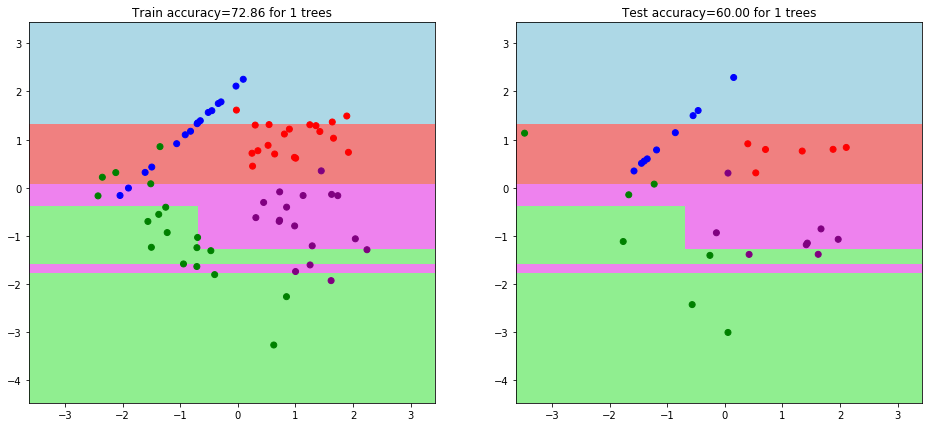

In [12]:
%%time
n_trees = 1
forest_1 = RandomForest(n_trees=n_trees) 
forest_1.fit(train_data, train_labels)
train_labels_1 = forest_1.tree_vote(train_data)
test_labels_1 = forest_1.tree_vote(test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_labels_1)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_labels_1)
visualize(train_data,  test_data, forest_1, train_accuracy, test_accuracy, n_trees)

CPU times: user 245 ms, sys: 6.28 ms, total: 251 ms
Wall time: 268 ms


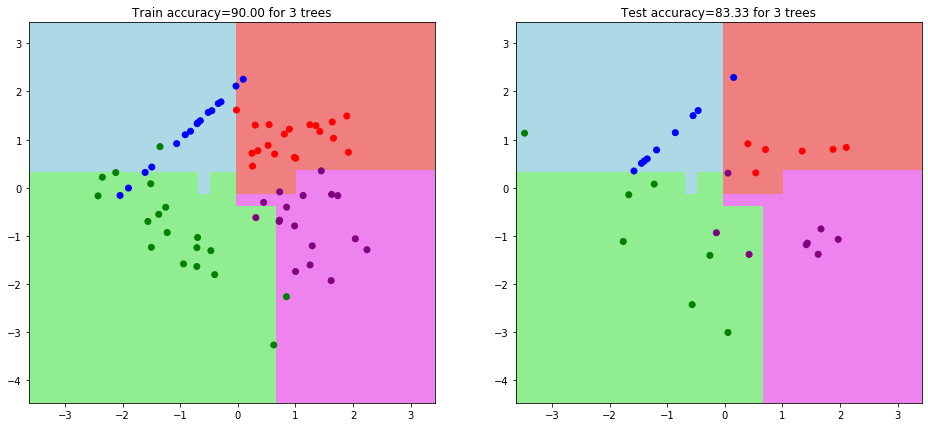

In [13]:
%%time
n_trees = 3
forest_3 = RandomForest(n_trees=n_trees) 
forest_3.fit(train_data, train_labels)
train_labels_3 = forest_3.tree_vote(train_data)
test_labels_3 = forest_3.tree_vote(test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_labels_3)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_labels_3)
visualize(train_data,  test_data, forest_3, train_accuracy, test_accuracy, n_trees)

CPU times: user 621 ms, sys: 12.8 ms, total: 634 ms
Wall time: 660 ms


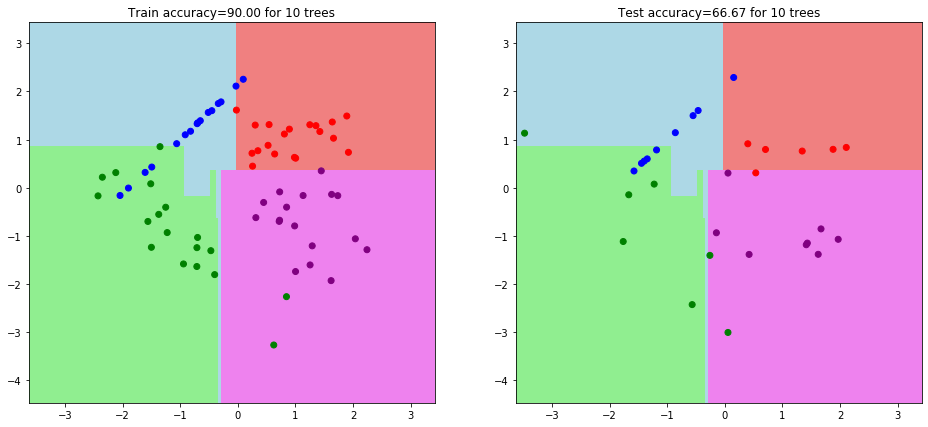

In [14]:
%%time
n_trees = 10
forest_10 = RandomForest(n_trees=n_trees) 
forest_10.fit(train_data, train_labels)
train_labels_10 = forest_10.tree_vote(train_data)
test_labels_10 = forest_10.tree_vote(test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_labels_10)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_labels_10)
visualize(train_data,  test_data, forest_10, train_accuracy, test_accuracy, n_trees)

CPU times: user 3.17 s, sys: 45.5 ms, total: 3.21 s
Wall time: 3.33 s


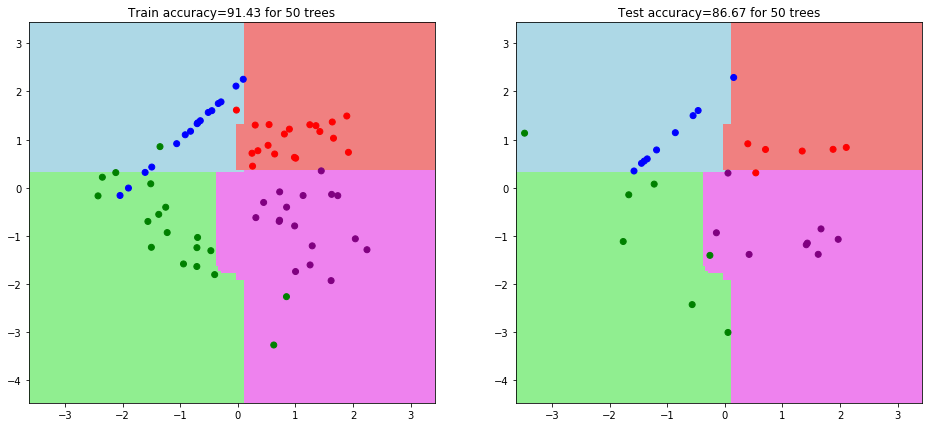

In [15]:
%%time
n_trees = 50
forest_50 = RandomForest(n_trees=n_trees) 
forest_50.fit(train_data, train_labels)
train_labels_50 = forest_50.tree_vote(train_data)
test_labels_50 = forest_50.tree_vote(test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_labels_50)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_labels_50)
visualize(train_data,  test_data, forest_50, train_accuracy, test_accuracy, n_trees)

CPU times: user 5.89 s, sys: 42.8 ms, total: 5.93 s
Wall time: 6.14 s


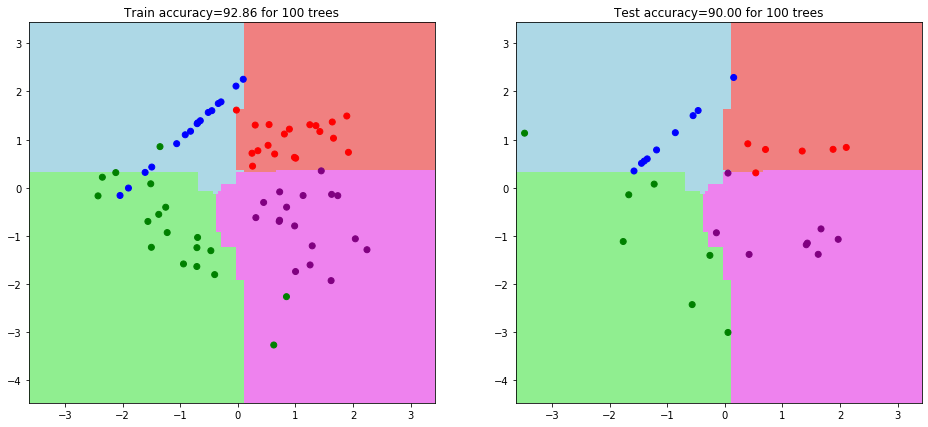

In [16]:
%%time
n_trees = 100
forest_100 = RandomForest(n_trees=n_trees) 
forest_100.fit(train_data, train_labels)
train_labels_100 = forest_100.tree_vote(train_data)
test_labels_100 = forest_100.tree_vote(test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_labels_100)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_labels_100)
visualize(train_data,  test_data, forest_100, train_accuracy, test_accuracy, n_trees)

### Задание 2
Используя файл Lesson_5_extended.ipynb (он в web5.zip в материалах):
#### Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

**Вывод:** точность предсказания возрастает с увеличением количества деревьев. В целом, разделяющая гиперплоскость выглядит довольно надежно и переобучения не наблюдается даже при большом количестве деревьев (100). 

### Задание 3*
Используя файл Lesson_5_extended.ipynb (он в web5.zip в материалах):
#### Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Вспомним, что каждое дерево $b_{n}$, составляющее случайный лес, строится на основе бутстрапированной выборки $X_{n}$. При этом примерно 37% объектов не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, это и называется _out-of-bag error_. Для каждог объекта $x_{i}$ мы можем найти деревья, которые на нем не обучались, и вычислить ошибку: она рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

<font color='DarkBlue'>**Мое понимание процесса:**<br>
1. Строим случайный лес с некоторым количеством деревьев. Каждое дерево обучается на бутстрапированной подвыборке исходной выборки.<br>
2. Для каждого дерева леса есть набор объектов, на котором оно НЕ обучалось.<br>
3. Чем больше деревьев, тем более вероятно, что каждый объект исходной выборки поучаствовал в обучении хотя бы одного дерева.<br>
4. Лес обучаем на ВСЕЙ исходной выборке данных, разбитой на бутстрапированные подвыборки.<br>
5. Качество классификации проверяем на наборе объектов, на котором не обучались деревья.<br>
    5.1. При построении каждого дерева фиксируем объекты, на котором оно не обучалось.<br>
    5.2. Собираем эти объекты в один тестовый массив данных.<br>
    5.3. Прогоняем каждый объект из тестового массива данных именно по тем деревьям, которые на них НЕ обучались.<br>
    5.4. Получаем предсказание для каждого объекта голосованием.<br>
    5.5. Сравниваем предсказанные результаты с исходными метками и считаем точность предсказания.<br>
6. То есть объекты из тестового массива данных прогоняются только по некоторым отдельным деревьям, а не по всему лесу в целом.<br>
</font>

In [17]:
# Класс дерева
# ИЗМЕНЕНИЯ: добавила атрибут oob_index для хранения неиспользованных индексов
class Tree_oob:
    
    def __init__(self, max_tree_depth_stop=100, # максимальная глубина дерева
                 max_leaf_num_stop=100, # максимальное количество листьев
                 min_leaf_object_stop=1, # максимальное количество объектов в листе
                 oob_index=[]): # индексы объектов, не попавших в обучающую бутстрапированную выборку 
        self.max_depth = max_tree_depth_stop
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_num_stop
        self.min_objects = min_leaf_object_stop
        self.oob_index = []
        self.oob_index += oob_index
        self.tree = None
    
    # Расчет критерия Джини
    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    # Расчет прироста
    def gain(self, left_labels, right_labels, root_gini):
        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
    # Разбиение датасета в узле
    def split(self, data, labels, column_index, t):
        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Реализуем генерацию подмножества признаков для нахождения разбиения в узле
    def get_subsample(self, len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = list(range(len_sample))

        len_subsample = int(np.sqrt(len_sample))

        subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

        return subsample
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_leaf_samples = 5

        root_gini = self.gini(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        feature_subsample_indices = self.get_subsample(n_features) # выбираем случайные признаки

        for index in feature_subsample_indices:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_gini)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels):
        gain, t, index = self.find_best_split(data, labels)
        
        #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth >= self.max_depth:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [18]:
# Класс леса
# ИЗМЕНЕНИЯ: функция bootstrap - добавила возврат неиспользованных индексов
# ИЗМЕНЕНИЯ: добавила функцию test_tree_vote, которая собирает тестовый массив данных и получает предсказания для него
class RandomForest_oob:
    def __init__(self, n_trees, # количествоо деревьев 
                 max_depth=50, # максимальная глубина деревьев
                 max_leaves=200, # максимальное количество листьев в деревьях
                 min_leaf_objects=1):  # минимальное количество объектов в листе
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_leaves = max_leaves
        self.min_leaf_objects = min_leaf_objects
        self.forest = []  
    
    # Реализуем генерацию 𝑁 бутстрап-выборок
    def get_bootstrap(self, data, labels, N):
        n_samples = data.shape[0] # размер совпадает с исходной выборкой
        bootstrap = []
        all_index = set(range(data.shape[0]))
        oob_index = set() # множество индексов, которые не попали в бутстрап

        for i in range(N):
            sample_index = np.random.randint(0, n_samples, size=n_samples)
            oob_index = all_index.difference(set(sample_index))
            b_data = data[sample_index]
            b_labels = labels[sample_index]

            bootstrap.append((b_data, b_labels, list(oob_index)))
        
        return bootstrap
    
    def fit(self, data, labels):
        forest = []
        bootstrap = self.get_bootstrap(data, labels, self.n_trees)

        for b_data, b_labels, b_oob_ind in bootstrap:
            new_tree = Tree_oob(self.max_depth, self.max_leaves, self.min_leaf_objects, b_oob_ind)
            new_tree.fit(b_data, b_labels)
            self.forest.append(new_tree)

        return self

    # предсказание голосованием деревьев
    def tree_vote(self, data):
        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            tree_vote = tree.predict(data)
            predictions.append(tree_vote)

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions
    
    # проверка точности предсказания на объектах, которые не попали в бутстрапированные выборки
    def test_tree_vote(self, data, labels):
        all_test_indexes = [] # индексы всех тестовых объектов
        test_data = [] # данные тестовых объектов
        test_labels = [] # актуальные метки классов тестовых объектов
        test_pred = [] # предсказанные метки классов для тестовых объектов
        test_predictions = {} # словарь для хранения предсказаний отдельных деревьев 
        # для каждого дерева собираем индексы тестовых объектов и получаем предсказания для них
        for tree in self.forest:
            test_indexes = tree.oob_index
            all_test_indexes += test_indexes
            tree_test_data = data[test_indexes]
            tree_test_labels = data[test_indexes]
            for i in test_indexes:
                result = tree.predict([data[i]])[0]
                if i in test_predictions:
                    test_predictions[i].append(result)
                else:
                    test_predictions[i] = [result]
        all_test_indexes = list(set(all_test_indexes))
        for j in all_test_indexes:
            # голосование для получения "максимального" класса объекта
            test_pred.append(max(zip((test_predictions[j].count(item) for item in set(test_predictions[j])), set(test_predictions[j])))[1])
        test_data = data[all_test_indexes]
        test_labels = labels[all_test_indexes]
        
        return test_data, test_pred, test_labels

Визуализировать здесь будем не разделяющими плоскостями, а наложением актуальных меток на предсказанные.<br>
Яркие метки - реальные значения меток, светлые ободки вокруг - предсказанные значения меток. То есть метка, у которой цвет ободка отличается от основного цвета, ошибочная.

In [19]:
def visualize_oob(train_data, train_labels, actual_train_labels, test_data, test_labels, actual_test_labels,
                  forest, train_accuracy, test_accuracy, n):
    plt.figure(figsize = (20, 10))
    # график обучающей выборки
    plt.subplot(1,2,1)
    plt.scatter(list(map(lambda x: x[0], train_data)), list(map(lambda x: x[1], train_data)), 
              c=train_labels, cmap=light_colors_oob, alpha=1, s=180);
    plt.scatter(list(map(lambda x: x[0], train_data)), list(map(lambda x: x[1], train_data)), 
              c=actual_train_labels, cmap=colors_oob, alpha=1, s=50);
    
    plt.title(f'Train accuracy={train_accuracy:.2f} for {n} trees and {len(train_data)} objects')
    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.scatter(list(map(lambda x: x[0], test_data)), list(map(lambda x: x[1], test_data)), 
              c=test_labels, cmap=light_colors_oob, alpha=1, s=180);
    plt.scatter(list(map(lambda x: x[0], test_data)), list(map(lambda x: x[1], test_data)), 
              c=actual_test_labels, cmap=colors_oob, alpha=1, s=50);
    
    plt.title(f'Test accuracy={test_accuracy:.2f} for {n} trees and {len(test_data)} objects')

In [20]:
# сгенерируем новые данные
# возьмем побольше данных для наглядности
classification_data_oob, classification_labels_oob = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                                 n_classes=4, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=3)

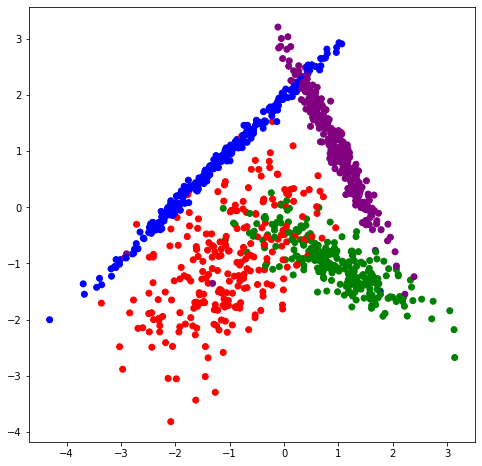

In [21]:
# визуализируем сгенерированные данные
colors_oob = ListedColormap(['red', 'blue', 'green', 'purple'])
light_colors_oob = ListedColormap(['coral', 'lightblue', 'lightgreen', 'violet'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data_oob)), list(map(lambda x: x[1], classification_data_oob)), 
              c=classification_labels_oob, cmap=colors_oob);

Сначала построим лес с 1 деревом, а затем с 3 и 50 деревьями.

In [22]:
%%time
n_trees = 1
forest_1_oob = RandomForest_oob(n_trees=n_trees) 
forest_1_oob.fit(classification_data_oob, classification_labels_oob)
train_labels_1_oob = forest_1_oob.tree_vote(classification_data_oob)
test_result = forest_1_oob.test_tree_vote(classification_data_oob, classification_labels_oob)
test_data_1_oob = test_result[0]
test_labels_1_oob = test_result[1]
test_actual_1_oob = test_result[2]
# Точность на обучающей выборке
train_accuracy = accuracy_metric(classification_labels_oob, train_labels_1_oob)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_actual_1_oob, test_labels_1_oob)
print(f'Train accuracy = {train_accuracy:.2f} and test accuracy = {test_accuracy:.2f} for {n_trees} trees.')

Train accuracy = 83.90 and test accuracy = 79.89 for 1 trees.
CPU times: user 488 ms, sys: 2.42 ms, total: 490 ms
Wall time: 491 ms


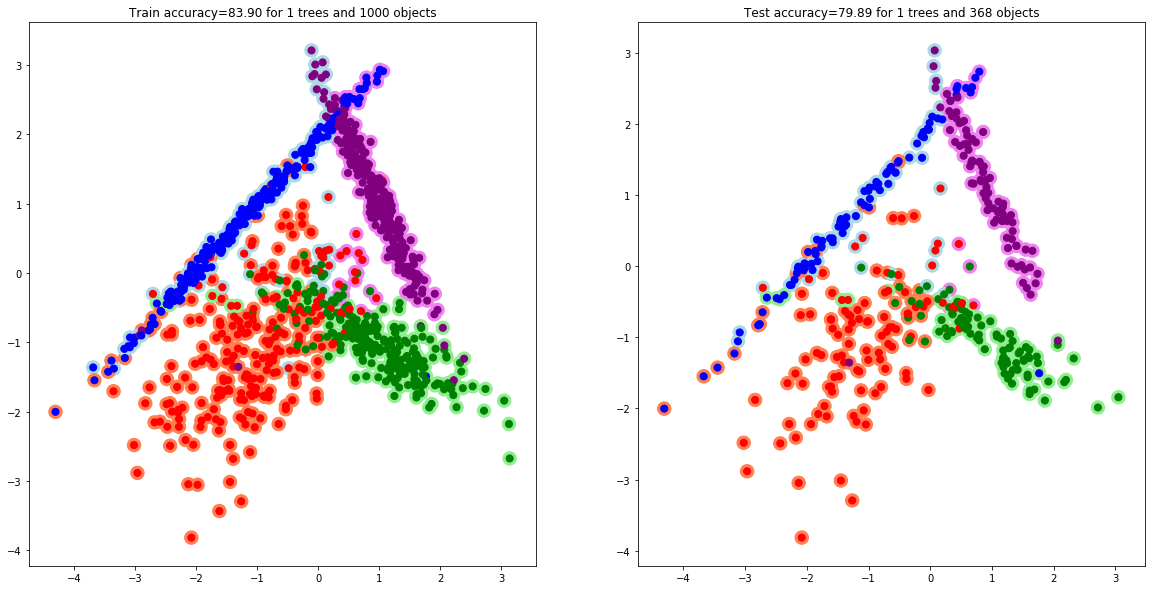

In [23]:
visualize_oob(classification_data_oob, train_labels_1_oob, classification_labels_oob, 
              test_data_1_oob, test_labels_1_oob, test_actual_1_oob,
                  forest_1_oob, train_accuracy, test_accuracy, n_trees)

In [24]:
%%time
n_trees = 3
forest_3_oob = RandomForest_oob(n_trees=n_trees) 
forest_3_oob.fit(classification_data_oob, classification_labels_oob)
train_labels_3_oob = forest_3_oob.tree_vote(classification_data_oob)
test_result = forest_3_oob.test_tree_vote(classification_data_oob, classification_labels_oob)
test_data_3_oob = test_result[0]
test_labels_3_oob = test_result[1]
test_actual_3_oob = test_result[2]
# Точность на обучающей выборке
train_accuracy = accuracy_metric(classification_labels_oob, train_labels_3_oob)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_actual_3_oob, test_labels_3_oob)
print(f'Train accuracy = {train_accuracy:.2f} and test accuracy = {test_accuracy:.2f} for {n_trees} trees.')

Train accuracy = 89.50 and test accuracy = 84.33 for 3 trees.
CPU times: user 1.53 s, sys: 7.8 ms, total: 1.54 s
Wall time: 1.54 s


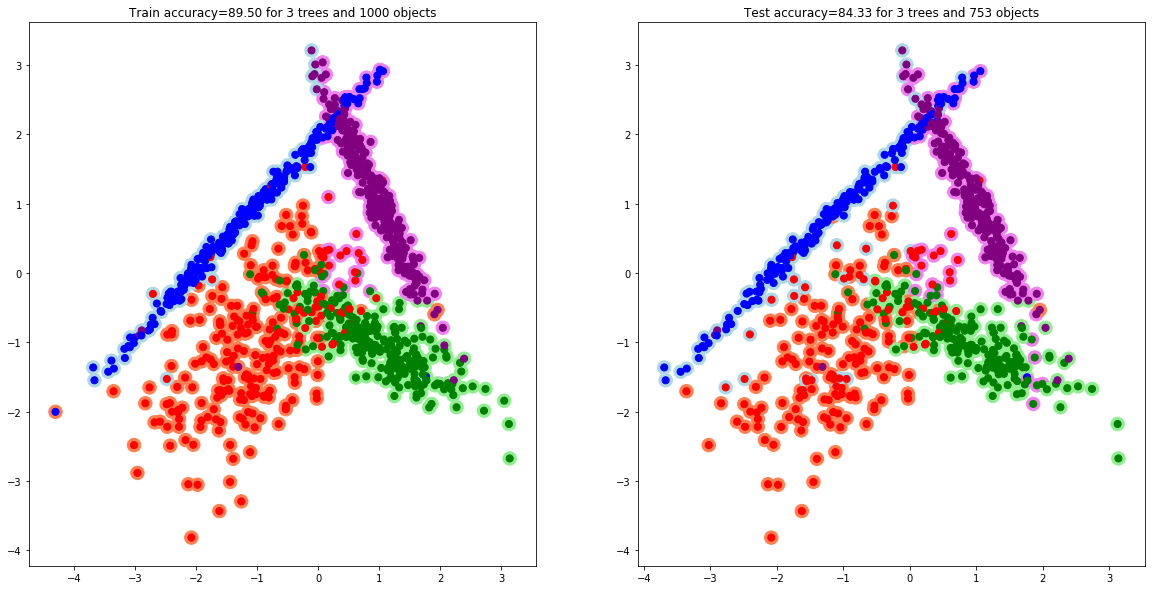

In [25]:
visualize_oob(classification_data_oob, train_labels_3_oob, classification_labels_oob, 
              test_data_3_oob, test_labels_3_oob, test_actual_3_oob,
                  forest_3_oob, train_accuracy, test_accuracy, n_trees)

In [26]:
%%time
n_trees = 50
forest_50_oob = RandomForest_oob(n_trees=n_trees) 
forest_50_oob.fit(classification_data_oob, classification_labels_oob)
train_labels_50_oob = forest_50_oob.tree_vote(classification_data_oob)
test_result = forest_50_oob.test_tree_vote(classification_data_oob, classification_labels_oob)
test_data_50_oob = test_result[0]
test_labels_50_oob = test_result[1]
test_actual_50_oob = test_result[2]
# Точность на обучающей выборке
train_accuracy = accuracy_metric(classification_labels_oob, train_labels_50_oob)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_actual_50_oob, test_labels_50_oob)
print(f'Train accuracy = {train_accuracy:.2f} and test accuracy = {test_accuracy:.2f} for {n_trees} trees.')

Train accuracy = 93.00 and test accuracy = 88.60 for 50 trees.
CPU times: user 30.4 s, sys: 260 ms, total: 30.7 s
Wall time: 32.6 s


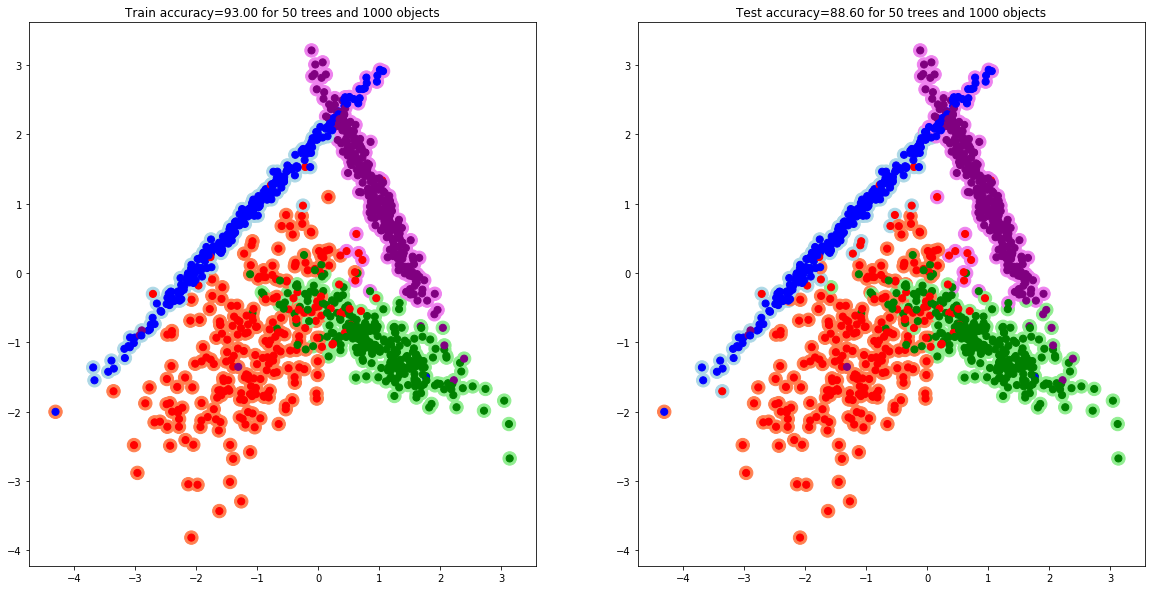

In [27]:
visualize_oob(classification_data_oob, train_labels_50_oob, classification_labels_oob, 
              test_data_50_oob, test_labels_50_oob, test_actual_50_oob,
                  forest_50_oob, train_accuracy, test_accuracy, n_trees)

В случае леса с 50 деревьями получилось, что тестовый массив данных включает в себя все объекты исходной выборки. То есть каждый объект не поучаствовал в обучении хотя бы одного дерева. 

### Задание 4*
Используя файл Lesson_5_extended.ipynb (он в web5.zip в материалах):
#### (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

В задаче **классификации** есть несколько способов определить критерий информативности.

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Энтропийный критерий_ или _энтропия Шеннона_ :

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$

In [28]:
def entropy(labels):  # Расчет энтропии
    entropy = 0
    classes = {} # словарь для хранения количества меток классов
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  энтропия Шеннона
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * np.log2(p)

    return entropy

In [29]:
# Расчет прироста
def gain(left_labels, right_labels, cur_entropy):
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return cur_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)